In [1]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import model_selection
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

import numpy as np
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV, train_test_split
from scipy.stats import randint as sp_randint
from time import time
from sklearn.metrics import roc_curve, auc
from scipy import interp
from pylab import rcParams
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score, precision_score, recall_score

In [2]:
rcParams['figure.figsize'] = 12, 8

In [3]:
df_alus = pd.read_csv('/home/alexshein/processed_pals/S10-20_L0-8_M5/AluS.csv', sep=';')
df_aluy = pd.read_csv('/home/alexshein/processed_pals/S10-20_L0-8_M5/AluY.csv', sep=';')
df_l1 = pd.read_csv('/home/alexshein/processed_pals/S10-20_L0-8_M5/L1_t.csv', sep=';')
df_l1.is_target=0

In [4]:
# Cut off auxiliary rows of alus d
df = pd.concat([
    pd.concat([df_alus, df_aluy]).sample(frac=len(df_l1)/(len(df_alus)+len(df_aluy))),
    df_l1,
]).sample(frac=1).reset_index(drop=True)
df = df[[i for i in list(df.columns) if i not in ('Unnamed: 0')]]
df = df.fillna(value=0.0)

In [5]:
df.describe()

,AA,AAA,AAC,AAG,AAT,AC,ACA,ACC,ACG,ACT,...,TGA,TGC,TGG,TGT,TT,TTA,TTC,TTG,TTT,is_target
count,12200.000000,12200.000000,12200.000000,12200.000000,12200.000000,12200.000000,12200.000000,12200.000000,12200.000000,12200.000000,...,12200.000000,12200.000000,12200.000000,12200.000000,12200.000000,12200.000000,12200.000000,12200.000000,12200.000000,12200.00000
mean,0.472705,0.047787,0.152213,0.016393,0.025164,0.823279,0.254016,0.161066,0.043033,0.106475,...,0.014344,0.294672,0.009180,0.253115,0.557131,0.009344,0.237131,0.055164,0.017049,0.50000
std,0.582621,0.220504,0.365575,0.126988,0.166768,0.922836,0.455748,0.367606,0.204147,0.309519,...,0.119598,0.557803,0.095377,0.454358,0.571345,0.098740,0.425533,0.233282,0.131968,0.50002
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.50000
75%,1.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.00000
max,4.000000,3.000000,2.000000,1.000000,2.000000,4.000000,2.000000,1.000000,2.000000,2.000000,...,2.000000,3.000000,1.000000,3.000000,4.000000,2.000000,2.000000,2.000000,2.000000,1.00000


In [6]:
df[df['is_target']==1]['GC precentage'].describe()

count    6100.000000
mean       42.784933
std         9.459335
min         0.000000
25%        36.000000
50%        45.454545
75%        50.000000
max        68.000000
Name: GC precentage, dtype: float64

In [7]:
df[df['is_target']==0]['GC precentage'].describe()

count    6100.000000
mean       27.638592
std         6.218705
min         0.000000
25%        24.000000
50%        28.000000
75%        32.000000
max        52.000000
Name: GC precentage, dtype: float64

In [8]:
dfX = df[[i for i in list(df.columns) if i not in ('is_target')]]
dfY = df['is_target']

In [9]:
rf = RandomForestClassifier(n_jobs=-1, n_estimators=300, max_depth=5)

In [10]:
def draw_roc_auc(dfX, dfY, rf):
    folded_data = model_selection.KFold(n_splits=5)
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    i = 0

    for k, (train, test) in enumerate(folded_data.split(dfX, dfY)):
        probas_ = rf.fit(dfX.iloc[train], dfY.iloc[train]).predict_proba(dfX.iloc[test])
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(dfY.iloc[test], probas_[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(
            fpr,
            tpr,
            lw=1,
            alpha=0.3,
            label='ROC fold %d (AUC = %0.3f)' % (k, roc_auc)
        )

    plt.plot(
        [0, 1],
        [0, 1],
        linestyle='--',
        lw=2,
        color='r',
        label='Luck',
        alpha=.8
    )
    fpr, tpr, thresholds = roc_curve(dfY.iloc[test], probas_[:, 1])

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        color='grey',
        alpha=.2,
        label=r'$\pm$ 1 std. dev.'
    )

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic for transposon recognition')
    plt.legend(loc="lower right")
    plt.show()
    list(sorted(zip(dfX.columns, rf.feature_importances_), key=lambda x:x[1], reverse=True))[:20]

In [11]:
def draw_precision_recall(dfX, dfY, rf):
    folded_data = model_selection.KFold(n_splits=5)
    precisions = []
    recalls = []
    accuracies = []
    for k, (train, test) in enumerate(folded_data.split(dfX, dfY)):
        rf.fit(dfX.iloc[train], dfY.iloc[train])
        probas_ = rf.predict_proba(dfX.iloc[test])
        predictions_ = rf.predict(dfX.iloc[test])
        precision, recall, _ = precision_recall_curve(dfY.iloc[test], probas_[:, 1])
        precisions.append(average_precision_score(dfY.iloc[test], probas_[:, 1]))
        recalls.append(recall_score(dfY.iloc[test], predictions_))
        accuracies.append(accuracy_score(dfY.iloc[test], predictions_))
        plt.step(
            recall,
            precision,
            alpha=0.5,
            where='post',
            label='Precision-recall fold {}'.format(k)
        )
    average_precision = np.mean(precisions)
    
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
              average_precision))
    plt.legend(loc="lower right")
    plt.show()
    print('Precision: ', average_precision, ' Recall: ', np.mean(recalls), ' Accuracy: ', np.mean(accuracies))

In [12]:
# Results WITH Di-Trinucleotides count features

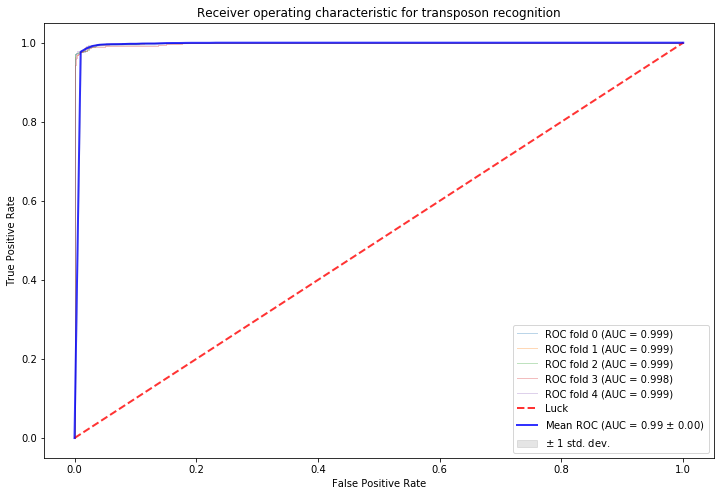

[('GA', 0.08358309425036291),
 ('AG', 0.06964053040584753),
 ('TG', 0.06767078415814425),
 ('GAG', 0.04738821782096006),
 ('CTC', 0.0425302633579125),
 ('GC precentage', 0.03986996338933205),
 ('TC', 0.03913923588500039),
 ('LS0Rise (RNA)', 0.03490471257943645),
 ('CA', 0.03229476740713025),
 ('RS0Rise (RNA)', 0.030541926612122013),
 ('RS0Hydrophilicity (RNA)', 0.029179544996844248),
 ('AA', 0.021207658472634228),
 ('RS0Slide (RNA)', 0.020258181780213068),
 ('RS7Rise (RNA)', 0.018150018586090312),
 ('LS6Rise (RNA)', 0.017393535856985005),
 ('RS6Rise (RNA)', 0.01724824928629367),
 ('RS0Tilt (RNA)', 0.01538533120227353),
 ('RS3Free energy (RNA)', 0.01467824941794885),
 ('AGA', 0.014544753053285493),
 ('LS6Hydrophilicity (RNA)', 0.01431249055878339)]

In [13]:
draw_roc_auc(dfX, dfY, rf)
list(sorted(zip(dfX.columns, rf.feature_importances_), key=lambda x:x[1], reverse=True))[:20]

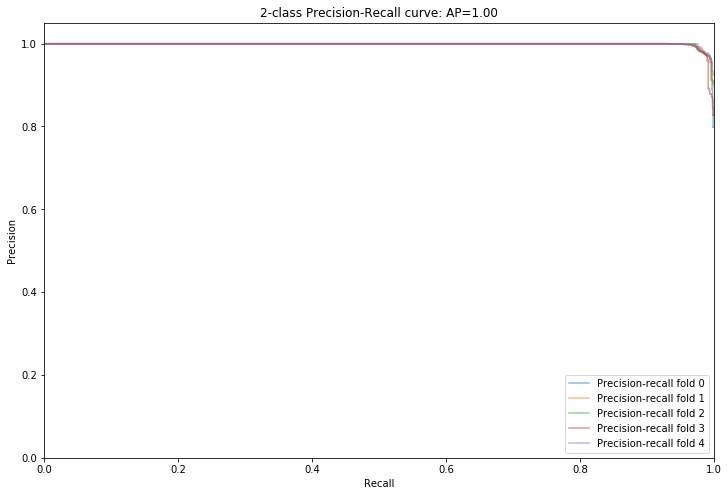

Precision:  0.9990187465086121  Recall:  0.968197266577014  Accuracy:  0.9827868852459016


In [14]:
draw_precision_recall(dfX, dfY, rf)

In [15]:
df2 = df[
    [col for col in list(df.columns) if col.startswith('LP') or
     col.startswith('LB') or
     col.startswith('RB') or
     col.startswith('LS') or
     col.startswith('RS') or
     col.startswith('GC p') or
     col == 'is_target'
    ]
]

In [16]:
df2.head()

,GC precentage,LB0A,LB0C,LB0G,LB0T,LB1A,LB1C,LB1G,LB1T,LB2A,...,RS8Entropy (RNA),RS8Free energy (RNA),RS8Hydrophilicity (RNA),RS8Rise (RNA),RS8Roll (RNA),RS8Shift (RNA),RS8Slide (RNA),RS8Tilt (RNA),RS8Twist (RNA),is_target
0,24.0,0,1,0,0,1,0,0,0,1,...,-27.8875,-2.134375,0.265,3.2525,8.5,0.053125,-1.523125,0.4375,31.4375,0
1,50.0,1,0,0,0,0,0,1,0,1,...,-27.8875,-2.134375,0.265,3.2525,8.5,0.053125,-1.523125,0.4375,31.4375,1
2,28.0,0,1,0,0,1,0,0,0,1,...,-29.5000,-2.240000,0.140,3.2400,4.8,0.230000,-1.430000,0.8000,32.0000,0
3,28.0,0,1,0,0,1,0,0,0,1,...,-29.5000,-2.240000,0.140,3.2400,4.8,0.230000,-1.430000,0.8000,32.0000,0
4,50.0,1,0,0,0,0,0,1,0,1,...,-27.8875,-2.134375,0.265,3.2525,8.5,0.053125,-1.523125,0.4375,31.4375,1


In [17]:
df2X = df2[[i for i in list(df2.columns) if i not in ('is_target')]]
df2Y = df2['is_target']

In [18]:
rf2 = RandomForestClassifier(n_jobs=-1, n_estimators=100, max_depth=5)


In [19]:
# Results WITHOUT Di-Trinucleotides count features

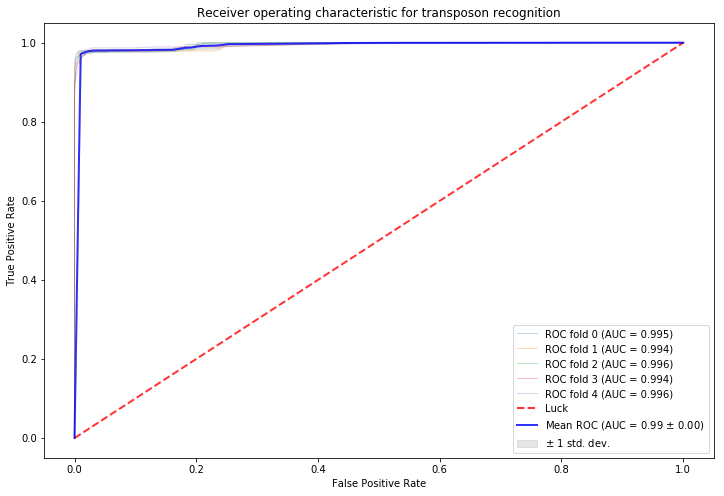

[('GC precentage', 0.07407087680484682),
 ('RS0Hydrophilicity (RNA)', 0.060644495600896284),
 ('RS0Rise (RNA)', 0.059396174593104645),
 ('RS0Entropy (RNA)', 0.04805245625018835),
 ('LB2G', 0.03423605416995475),
 ('RS0Free energy (RNA)', 0.03400257008774885),
 ('LS6Rise (RNA)', 0.030891848216372787),
 ('RS6Hydrophilicity (RNA)', 0.030519309112264095),
 ('LS6Hydrophilicity (RNA)', 0.02922640100547318),
 ('RS0Tilt (RNA)', 0.028116408272613094),
 ('LS0Rise (RNA)', 0.026232165641094672),
 ('RS3Rise (RNA)', 0.024574397818666292),
 ('RS0Slide (RNA)', 0.0224044677648764),
 ('LS0Tilt (RNA)', 0.019707349684825026),
 ('RS7Rise (RNA)', 0.0185179890159445),
 ('LS0Twist (RNA)', 0.01751468046447627),
 ('RS6Rise (RNA)', 0.016799861501195765),
 ('RS6Twist (RNA)', 0.016461938058812322),
 ('LS7Rise (RNA)', 0.014846515968385342),
 ('LS6Enthalpy (RNA)', 0.014346410448086575)]

In [20]:
draw_roc_auc(df2X, df2Y, rf2)

list(sorted(zip(df2X.columns, rf2.feature_importances_), key=lambda x:x[1], reverse=True))[:20]
# top_features = list(sorted(zip(df2X.columns, rf2.feature_importances_), key=lambda x: x[1], reverse=True))
# top_features

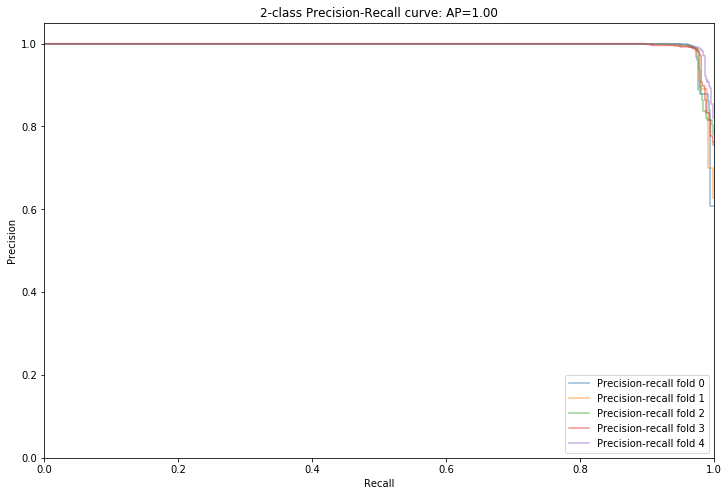

Precision:  0.9963253190435715  Recall:  0.9560894010462802  Accuracy:  0.975655737704918


In [21]:
draw_precision_recall(df2X, df2Y, rf2)

In [22]:
top_features = list(sorted(zip(df2X.columns, rf2.feature_importances_), key=lambda x:x[1], reverse=True))[:20]
pd.DataFrame(
    columns=df2X.columns, data=[
        df2X[df2Y==1].mean(),
        df2X[df2Y==0].mean(),
        df2X[df2Y==1].std(),
        df2X[df2Y==0].std()
    ],
    index=['Mean t', 'Mean f', 'Std t', 'Std f']
).round(2)[list(filter(bool, map(lambda x: x[0], top_features)))[:20]]

,RS0Hydrophilicity (RNA),GC precentage,LS0Rise (RNA),LS6Rise (RNA),RS0Rise (RNA),RS0Enthalpy (RNA),RS6Rise (RNA),RS0Free energy (RNA),RS0Entropy (RNA),LS6Tilt (RNA),RS6Hydrophilicity (RNA),RS0Slide (RNA),LS6Hydrophilicity (RNA),LB2G,LB1G,RS7Enthalpy (RNA),RS2Rise (RNA),RS3Rise (RNA),LS0Twist (RNA),LS7Rise (RNA)
Mean t,0.42,42.78,3.28,3.33,3.34,-11.86,3.29,-2.28,-30.88,0.96,0.43,-1.63,0.15,0.21,0.68,-11.75,3.26,3.28,30.55,3.28
Mean f,0.30,27.64,3.22,3.25,3.23,-10.03,3.23,-1.90,-26.22,0.49,0.26,-1.46,0.26,0.03,0.03,-10.69,3.24,3.23,31.30,3.23
Std t,0.10,9.46,0.06,0.07,0.06,0.87,0.04,0.16,2.36,0.42,0.12,0.10,0.08,0.41,0.47,0.84,0.03,0.04,0.87,0.03
Std f,0.08,6.22,0.05,0.03,0.04,1.75,0.05,0.53,3.92,0.20,0.03,0.10,0.03,0.17,0.18,0.64,0.03,0.04,0.63,0.06
